<a href="https://colab.research.google.com/github/Muntasir2179/bangla-accent-classification/blob/model-testing/Accent_Classification_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and dataset

In [1]:
!pip install resampy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.4 MB/s eta 0:00:00


In [2]:
# data visualization libraries
import resampy
import librosa
import pandas as pd
import os
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# data preprocessing libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# model building libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D

In [3]:
# readomg actual audio metadata
audio_dataset_path ='/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/'
metadata = pd.read_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio_trace_metadata.csv')

In [4]:
metadata = metadata.sample(frac=1, random_state=42)
metadata.head()

,file_name,folder_name,accent
1582,sylhet_audio_73.wav,sylhet,sylhet
1626,thakurgaon_audio_18.wav,thakurgaon,thakurgaon
416,chottgram_audio_36.wav,chottogram,chottogram
1414,shatkhira_audio_32.wav,shatkhira,shatkhira
1620,thakurgaon_audio_12.wav,thakurgaon,thakurgaon


In [5]:
len(metadata)

1675

In [6]:
metadata['accent'].value_counts()

chottogram     216
noakhali       214
sylhet         193
pabna          164
bogura         150
rajshahi       126
maymenshing    125
barishal       114
puran dhaka    104
madaripur       90
kurigram        80
thakurgaon      66
shatkhira       33
Name: accent, dtype: int64

# Extracting features

## Data augmentation functions

In [7]:
import librosa

# function to add noise to original sound
def add_white_noise(signal, noise_factor):
    noise = np.random.normal(0, signal.std(), signal.size)
    augmented_signal = signal + noise * noise_factor
    return augmented_signal

# scaling the pitch
def pitch_scale(signal, sr, num_semitones):
    return librosa.effects.pitch_shift(y=signal, sr=sr, n_steps=num_semitones)

# invert polarity
def invert_polarity(signal):
    return signal * -1

def random_gain(signal, min_gain_factor, max_gain_factor):
    gain_factor = np.random.uniform(min_gain_factor, max_gain_factor)
    return signal * gain_factor

# applying all augmentation
def augment_audio(signal, sr, noise_factor=0.05, num_semitones=0.5, min_gain_factor=2, max_gain_factor=4):
    augmented_signal = add_white_noise(signal, noise_factor)
    augmented_signal = pitch_scale(augmented_signal, sr, num_semitones)
    augmented_signal = invert_polarity(augmented_signal)
    augmented_signal = random_gain(augmented_signal, min_gain_factor, max_gain_factor)
    return augmented_signal

## Feature extraction with data augmentation

In [8]:
# defining a function that can extract features from audio files
def features_extractor(file_name):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')

    # actual audio features extraction
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)

    # augmented audio features extraction
    augmented_audio = augment_audio(signal=audio, sr=sample_rate)
    mfccs_features_augmented = librosa.feature.mfcc(y=augmented_audio, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features_augmented = np.mean(mfccs_features_augmented.T, axis=0)

    return mfccs_scaled_features, mfccs_scaled_features_augmented

In [9]:
# collecting features for all the audio files
from tqdm import tqdm

extracted_features = []

for index_num, row in tqdm(metadata.iterrows()):
  accent_label = row['accent']
  file_path = '/content/drive/MyDrive/Datasets/Bangla Accent Dataset/audio/' + str(row['folder_name']) + '/' + str(row['file_name'])
  actual_features, augmented_features = features_extractor(file_path)

  # adding actual and augmented features to our features
  extracted_features.append([actual_features, accent_label])
  extracted_features.append([augmented_features, accent_label])

1675it [19:57,  1.40it/s]


In [10]:
# converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-306.27716, 118.50889, -12.945208, 24.958263,...",sylhet
1,"[-177.3331856210959, 72.4183146268559, -1.6383...",sylhet
2,"[-230.6326, 120.675415, -47.888245, 21.010283,...",thakurgaon
3,"[-88.44902973999099, 76.80736893628709, -22.27...",thakurgaon
4,"[-323.1557, 124.41193, -34.882835, 20.073555, ...",chottogram


In [11]:
# saving the extracted features dataframe into drive for later use
extracted_features_df.to_csv('/content/drive/MyDrive/Datasets/Bangla Accent Dataset/128_audio_features.csv')

In [12]:
len(extracted_features_df)

3350

In [13]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [14]:
X.shape, y.shape

((3350, 128), (3350,))

# Applying onehot encoding on labels

In [15]:
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
y

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
y.shape

(3350, 13)

In [17]:
import pickle
with open("/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/onehot_encoder_accent_classification.pkl", "wb") as f:
    pickle.dump(encoder, f)

# Spliting dataset into train and test

In [18]:
# split the data to train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# print the details
print("Number of training samples = ", X_train.shape[0])
print("Number of testing samples = ", X_test.shape[0])
print("Number of validation samples = ", X_valid.shape[0])

Number of training samples =  2010
Number of testing samples =  670
Number of validation samples =  670


# Helper functions for plotting and evaluation

In [19]:
# function for Ploting history (also known as a loss curve or a training curve)
def plot_history(history):
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['accuracy'], label='Training Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [20]:
# function to predict and generate decoded value of labels
def model_prediction(x_test, y_true, model, number_of_labels, onehot_encoder):
  y_pred = model.predict(x_test, verbose=0)
  predictions = []
  for row in y_pred:
    label = np.zeros(number_of_labels)
    label[np.argmax(row)] = 1
    label.reshape(1, -1)
    predictions.append(label.tolist())
    label = None
  y_test_decoded = onehot_encoder.inverse_transform(y_true)
  y_pred_decoded = onehot_encoder.inverse_transform(predictions)
  return y_pred_decoded, y_test_decoded

In [21]:
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def show_evaluation_parameters(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  print('Accuracy score : ', accuracy_score(y_test_for_eval, predictions))
  print('Precision score: ', precision_score(y_test_for_eval, predictions, average='weighted'))
  print('Recall score   : ', recall_score(y_test_for_eval, predictions, average='weighted'))
  print('F1 Score       : ', f1_score(y_test_for_eval, predictions, average='weighted'))
  print('\n--------------------------------------------\n')
  print(classification_report(y_test_for_eval, predictions))

In [22]:
def show_confusion_matrix(X_test, y_test, ANN_Model, number_of_labels, encoder):
  predictions, y_test_for_eval = model_prediction(X_test, y_test, ANN_Model, number_of_labels, encoder)
  cm = confusion_matrix(y_test_for_eval, predictions, labels=metadata['accent'].unique())
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=metadata['accent'].unique())
  fig, ax = plt.subplots(figsize=(20,13))
  disp.plot(ax=ax)
  plt.show()

# Building ANN model

In [66]:
# Construct model
num_labels = y.shape[1]

def create_ANN_model():
  ANN_Model = Sequential()
  ANN_Model.add(Dense(1000, activation="relu", input_shape=(128,)))
  ANN_Model.add(Dropout(0.2))
  ANN_Model.add(Dense(750, activation="relu"))
  ANN_Model.add(Dropout(0.2))
  ANN_Model.add(Dense(500, activation="relu"))
  ANN_Model.add(Dropout(0.2))
  ANN_Model.add(Dense(250, activation="relu"))
  ANN_Model.add(Dropout(0.2))
  ANN_Model.add(Dense(100, activation="relu"))
  ANN_Model.add(Dropout(0.2))
  ANN_Model.add(Dense(50, activation="relu"))
  # ANN_Model.add(Dropout(0.2))
  # ANN_Model.add(Dense(30, activation="relu"))
  ANN_Model.add(Dense(num_labels, activation="softmax"))
  return ANN_Model

In [67]:
ANN_Model = create_ANN_model()

ANN_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0008),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

In [68]:
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('val_accuracy') > 0.91:
      self.model.stop_training = True

custom_callback = MyCallback()

def lr_scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

scheduler_callback = LearningRateScheduler(lr_scheduler)

ckeckpoint_path = '/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/model checkpoints'

checkpoint_callback = ModelCheckpoint(filepath = ckeckpoint_path,
                                      monitor = 'val_accuracy',
                                      verbose = 0,
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'max',
                                      save_freq = 'epoch')

In [69]:
num_epochs = 150
num_batch_size = 5

ANN_Results = ANN_Model.fit(X_train,
                            y_train,
                            batch_size=num_batch_size,
                            epochs=num_epochs,
                            validation_data=(X_test, y_test),
                            callbacks=[checkpoint_callback]
                            )

Epoch 1/150
402/402 [==============================] - 6s 10ms/step - loss: 2.9943 - accuracy: 0.1303 - val_loss: 2.3731 - val_accuracy: 0.1776
Epoch 2/150
402/402 [==============================] - 4s 10ms/step - loss: 2.3878 - accuracy: 0.1627 - val_loss: 2.2226 - val_accuracy: 0.2433
Epoch 3/150
402/402 [==============================] - 3s 8ms/step - loss: 2.2094 - accuracy: 0.2204 - val_loss: 1.9626 - val_accuracy: 0.2821
Epoch 4/150
402/402 [==============================] - 3s 8ms/step - loss: 1.9575 - accuracy: 0.3254 - val_loss: 1.6884 - val_accuracy: 0.4224
Epoch 5/150
402/402 [==============================] - 5s 12ms/step - loss: 1.6993 - accuracy: 0.4189 - val_loss: 1.5316 - val_accuracy: 0.5313
Epoch 6/150
402/402 [==============================] - 3s 8ms/step - loss: 1.4990 - accuracy: 0.4975 - val_loss: 1.3397 - val_accuracy: 0.5448
Epoch 7/150
402/402 [==============================] - 2s 5ms/step - loss: 1.3717 - accuracy: 0.5582 - val_loss: 1.5458 - val_accuracy: 0.5

In [70]:
# loading the model's checkpoints
ANN_Model.load_weights(ckeckpoint_path)

In [71]:
test_accuracy=ANN_Model.evaluate(X_test, y_test, verbose=0)
print(test_accuracy[1])

0.9059701561927795


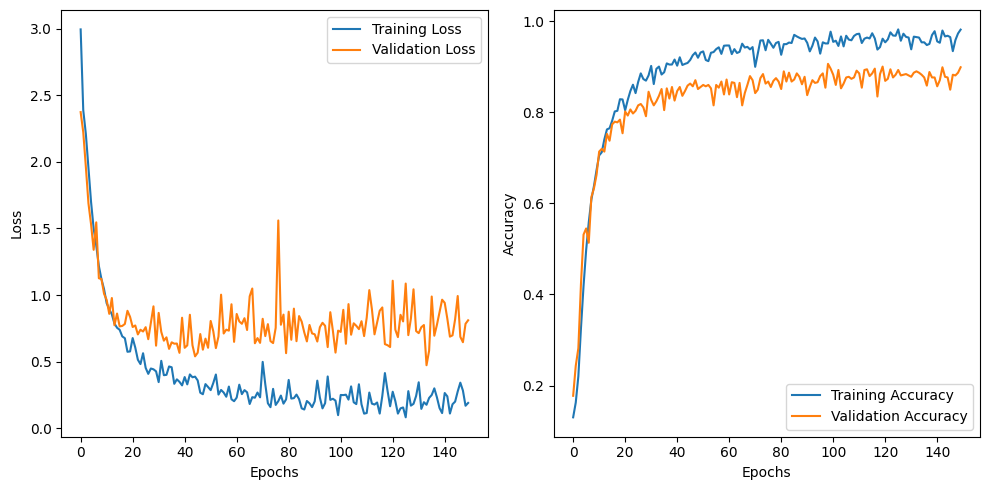

In [72]:
plot_history(ANN_Results)

In [73]:
show_evaluation_parameters(X_test, y_test, ANN_Model, num_labels, encoder)

Accuracy score :  0.9059701492537313
Precision score:  0.9175243630012365
Recall score   :  0.9059701492537313
F1 Score       :  0.9080422815130548

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.93      0.93      0.93        41
      bogura       0.98      0.92      0.95        50
  chottogram       0.98      0.84      0.90        94
    kurigram       0.97      0.97      0.97        30
   madaripur       1.00      1.00      1.00        45
 maymenshing       0.94      0.96      0.95        46
    noakhali       0.91      0.95      0.93        92
       pabna       0.67      0.92      0.78        62
 puran dhaka       0.97      0.82      0.89        39
    rajshahi       0.98      0.81      0.88        52
   shatkhira       1.00      0.93      0.96        14
      sylhet       0.87      0.89      0.88        73
  thakurgaon       0.88      0.94      0.91        32

    accuracy                           0.91    

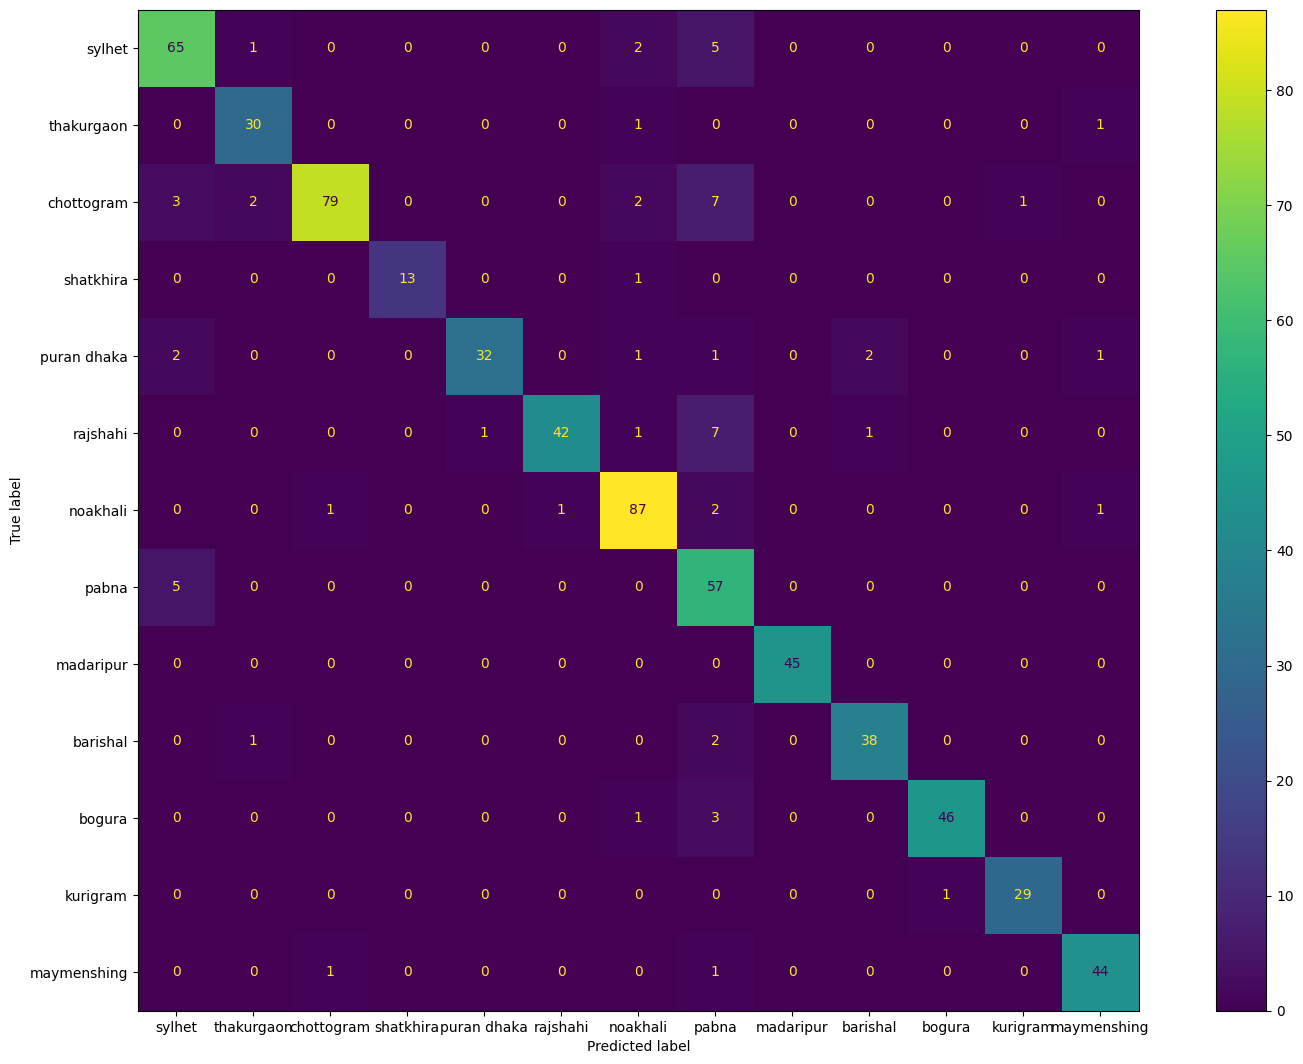

In [74]:
show_confusion_matrix(X_test, y_test, ANN_Model, num_labels, encoder)

## Performance on validation data

In [75]:
show_evaluation_parameters(X_valid, y_valid, ANN_Model, num_labels, encoder)

Accuracy score :  0.8731343283582089
Precision score:  0.8927039698352612
Recall score   :  0.8731343283582089
F1 Score       :  0.8755399281725672

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.88      0.95      0.91        44
      bogura       0.98      0.84      0.90        61
  chottogram       0.96      0.86      0.91        80
    kurigram       0.91      0.94      0.92        32
   madaripur       0.97      1.00      0.99        37
 maymenshing       1.00      0.95      0.98        44
    noakhali       0.83      0.90      0.86        67
       pabna       0.64      0.91      0.75        81
 puran dhaka       1.00      0.70      0.83        44
    rajshahi       0.95      0.72      0.82        53
   shatkhira       1.00      0.85      0.92        13
      sylhet       0.87      0.84      0.86        88
  thakurgaon       0.87      1.00      0.93        26

    accuracy                           0.87    

## Saving and loading trained model

In [ ]:
# saving the model
ANN_Model.save('/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/ANN_Model_val_acc_93%.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# loading the model
loaded_ann_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Accent Classification/Saved Models/ANN_Model_val_acc_93%.h5')

In [ ]:
result = loaded_ann_model.evaluate(X_test, y_test, verbose=0)
print(result[1])

0.9281768202781677


# Building CNN1D model

In [ ]:
CNN1D_Model = Sequential()
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu", input_shape=(X_train.shape[1], 1),))
CNN1D_Model.add(BatchNormalization())
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(256, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(128, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Conv1D(64, 5, strides=1, padding="same", activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(MaxPooling1D(3, strides=2, padding="same"))
CNN1D_Model.add(Flatten())
CNN1D_Model.add(Dense(units=1024, activation="relu"))
CNN1D_Model.add(Dropout(0.3))
CNN1D_Model.add(Dense(units=num_labels, activation="softmax"))

In [ ]:
CNN1D_Model.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [ ]:
CNN1D_Results = CNN1D_Model.fit(X_train,
                                y_train,
                                batch_size=5,
                                epochs=250,
                                validation_data=(X_test, y_test))

Epoch 1/250
390/390 [==============================] - 11s 7ms/step - loss: 2.4791 - accuracy: 0.1974 - val_loss: 2.1791 - val_accuracy: 0.2431
Epoch 2/250
390/390 [==============================] - 2s 6ms/step - loss: 2.1739 - accuracy: 0.2728 - val_loss: 2.0687 - val_accuracy: 0.2892
Epoch 3/250
390/390 [==============================] - 2s 6ms/step - loss: 1.9720 - accuracy: 0.3328 - val_loss: 1.8620 - val_accuracy: 0.3831
Epoch 4/250
390/390 [==============================] - 3s 8ms/step - loss: 1.8548 - accuracy: 0.3769 - val_loss: 1.9162 - val_accuracy: 0.3785
Epoch 5/250
390/390 [==============================] - 4s 9ms/step - loss: 1.7684 - accuracy: 0.4159 - val_loss: 1.8521 - val_accuracy: 0.4292
Epoch 6/250
390/390 [==============================] - 2s 6ms/step - loss: 1.7206 - accuracy: 0.4067 - val_loss: 1.7054 - val_accuracy: 0.5000
Epoch 7/250
390/390 [==============================] - 2s 6ms/step - loss: 1.6495 - accuracy: 0.4492 - val_loss: 1.7300 - val_accuracy: 0.393

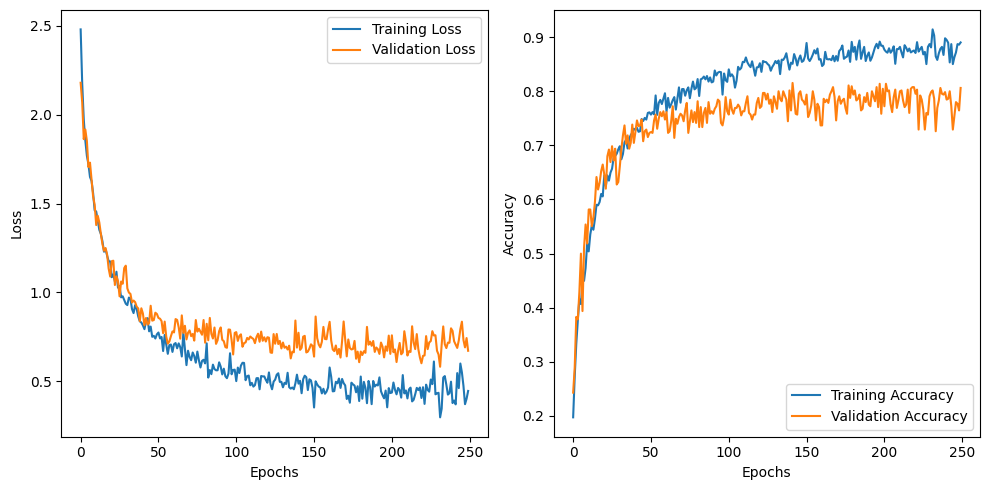

In [ ]:
plot_history(CNN1D_Results)

In [ ]:
show_evaluation_parameters(X_test, y_test, CNN1D_Model, num_labels, encoder)

Accuracy score :  0.8061538461538461
Precision score:  0.831554982376226
Recall score   :  0.8061538461538461
F1 Score       :  0.8124952510121707

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.97      0.87      0.92        39
      bogura       0.88      0.88      0.88        49
  chottogram       0.90      0.75      0.81       103
    kurigram       0.96      0.77      0.85        30
   madaripur       1.00      1.00      1.00        35
 maymenshing       0.94      0.88      0.91        52
    noakhali       0.77      0.69      0.73        78
       pabna       0.48      0.82      0.61        56
 puran dhaka       0.78      0.78      0.78        45
    rajshahi       0.87      0.76      0.81        59
   shatkhira       0.90      1.00      0.95         9
      sylhet       0.75      0.83      0.79        65
  thakurgaon       0.82      0.77      0.79        30

    accuracy                           0.81     

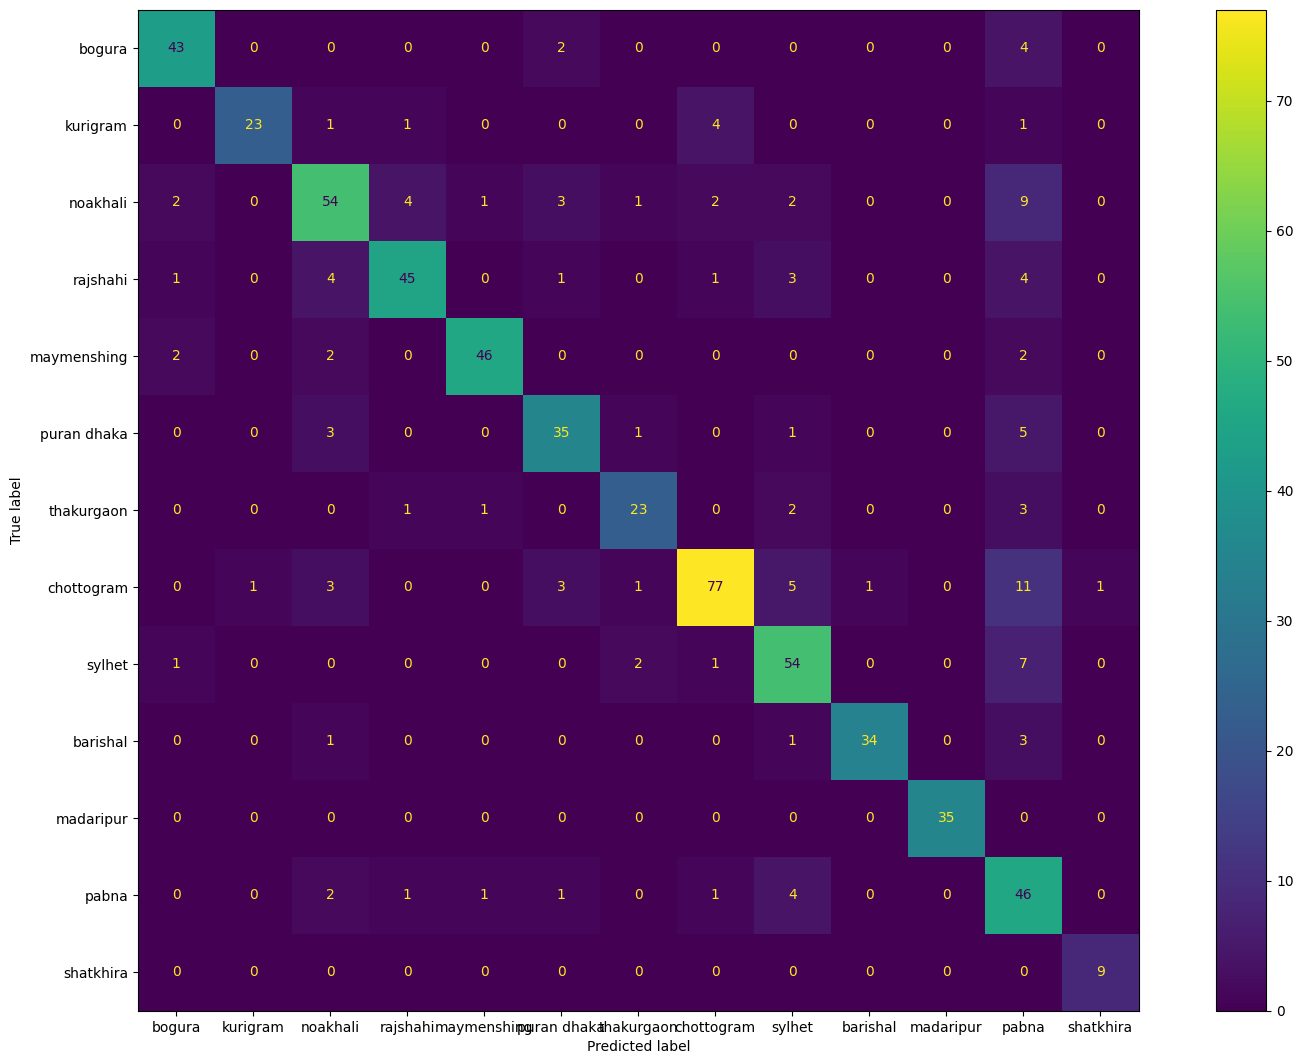

In [ ]:
show_confusion_matrix(X_test, y_test, CNN1D_Model, num_labels, encoder)

## Performance on validation data

In [ ]:
show_evaluation_parameters(X_valid, y_valid, CNN1D_Model, num_labels, encoder)

Accuracy score :  0.7876923076923077
Precision score:  0.8171053594164998
Recall score   :  0.7876923076923077
F1 Score       :  0.7900947248706336

--------------------------------------------

              precision    recall  f1-score   support

    barishal       1.00      0.76      0.86        46
      bogura       0.86      0.89      0.88        36
  chottogram       0.78      0.70      0.74        84
    kurigram       0.95      0.51      0.67        39
   madaripur       0.93      1.00      0.96        37
 maymenshing       0.93      0.96      0.95        56
    noakhali       0.88      0.73      0.80        86
       pabna       0.52      0.88      0.65        69
 puran dhaka       0.79      0.64      0.71        36
    rajshahi       0.78      0.76      0.77        37
   shatkhira       0.79      1.00      0.88        15
      sylhet       0.77      0.80      0.78        83
  thakurgaon       0.83      0.73      0.78        26

    accuracy                           0.79    

# Building CNN2D model

In [ ]:
# reshaping features to pass into the model
X_train_reshaped = X_train.reshape(X_train.shape[0], 16, 8, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 16, 8, 1)
X_valid_reshaped = X_valid.reshape(X_valid.shape[0], 16, 8, 1)

In [ ]:
CNN2D_Model = Sequential()
CNN2D_Model.add(Conv2D(64, (3, 3), padding="same", activation="tanh", input_shape=(16, 8, 1)))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Conv2D(128, (3, 3), padding="same", activation="tanh"))
CNN2D_Model.add(MaxPool2D(pool_size=(2, 2)))
CNN2D_Model.add(Dropout(0.1))
CNN2D_Model.add(Flatten())
CNN2D_Model.add(Dense(256, activation="tanh"))
CNN2D_Model.add(Dense(num_labels, activation="softmax"))

In [ ]:
CNN2D_Model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

In [ ]:
CNN2D_Results = CNN2D_Model.fit(X_train_reshaped,
                                y_train,
                                batch_size=5,
                                epochs=13,
                                validation_data=(X_test_reshaped, y_test))

Epoch 1/13
390/390 [==============================] - 3s 5ms/step - loss: 1.7517 - accuracy: 0.4605 - val_loss: 1.2953 - val_accuracy: 0.5862
Epoch 2/13
390/390 [==============================] - 2s 4ms/step - loss: 1.0081 - accuracy: 0.6882 - val_loss: 1.5055 - val_accuracy: 0.5462
Epoch 3/13
390/390 [==============================] - 2s 5ms/step - loss: 0.7661 - accuracy: 0.7574 - val_loss: 0.8440 - val_accuracy: 0.7323
Epoch 4/13
390/390 [==============================] - 2s 6ms/step - loss: 0.5592 - accuracy: 0.8108 - val_loss: 0.9009 - val_accuracy: 0.7185
Epoch 5/13
390/390 [==============================] - 2s 5ms/step - loss: 0.3860 - accuracy: 0.8713 - val_loss: 0.7338 - val_accuracy: 0.7738
Epoch 6/13
390/390 [==============================] - 2s 4ms/step - loss: 0.2835 - accuracy: 0.9108 - val_loss: 0.7811 - val_accuracy: 0.7569
Epoch 7/13
390/390 [==============================] - 2s 4ms/step - loss: 0.2190 - accuracy: 0.9282 - val_loss: 0.7539 - val_accuracy: 0.8031
Epoch 

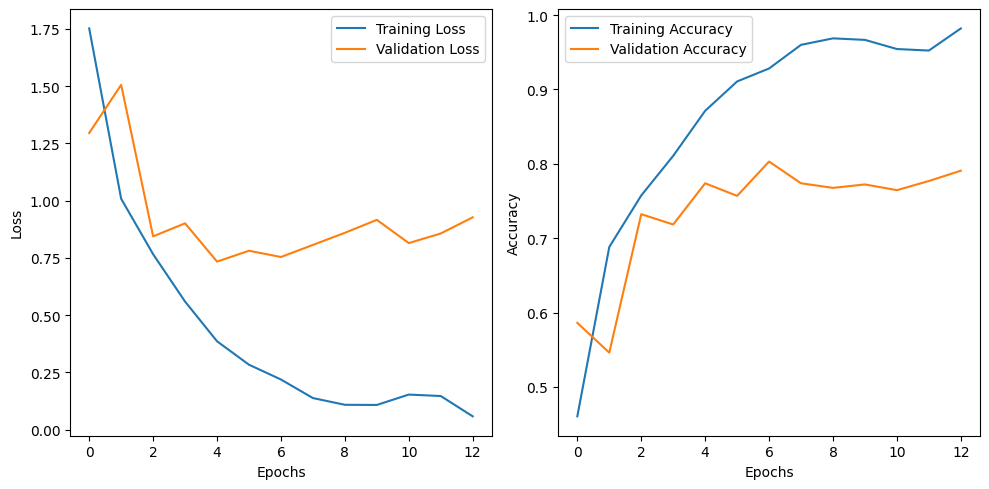

In [ ]:
plot_history(CNN2D_Results)

In [ ]:
show_evaluation_parameters(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)

Accuracy score :  0.7907692307692308
Precision score:  0.8261041450092474
Recall score   :  0.7907692307692308
F1 Score       :  0.79577620987818

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.94      0.74      0.83        39
      bogura       0.93      0.88      0.91        49
  chottogram       0.94      0.73      0.82       103
    kurigram       0.71      0.90      0.79        30
   madaripur       0.92      1.00      0.96        35
 maymenshing       0.91      0.83      0.87        52
    noakhali       0.79      0.79      0.79        78
       pabna       0.48      0.88      0.62        56
 puran dhaka       0.83      0.78      0.80        45
    rajshahi       0.83      0.68      0.75        59
   shatkhira       0.89      0.89      0.89         9
      sylhet       0.73      0.83      0.78        65
  thakurgaon       0.88      0.47      0.61        30

    accuracy                           0.79      

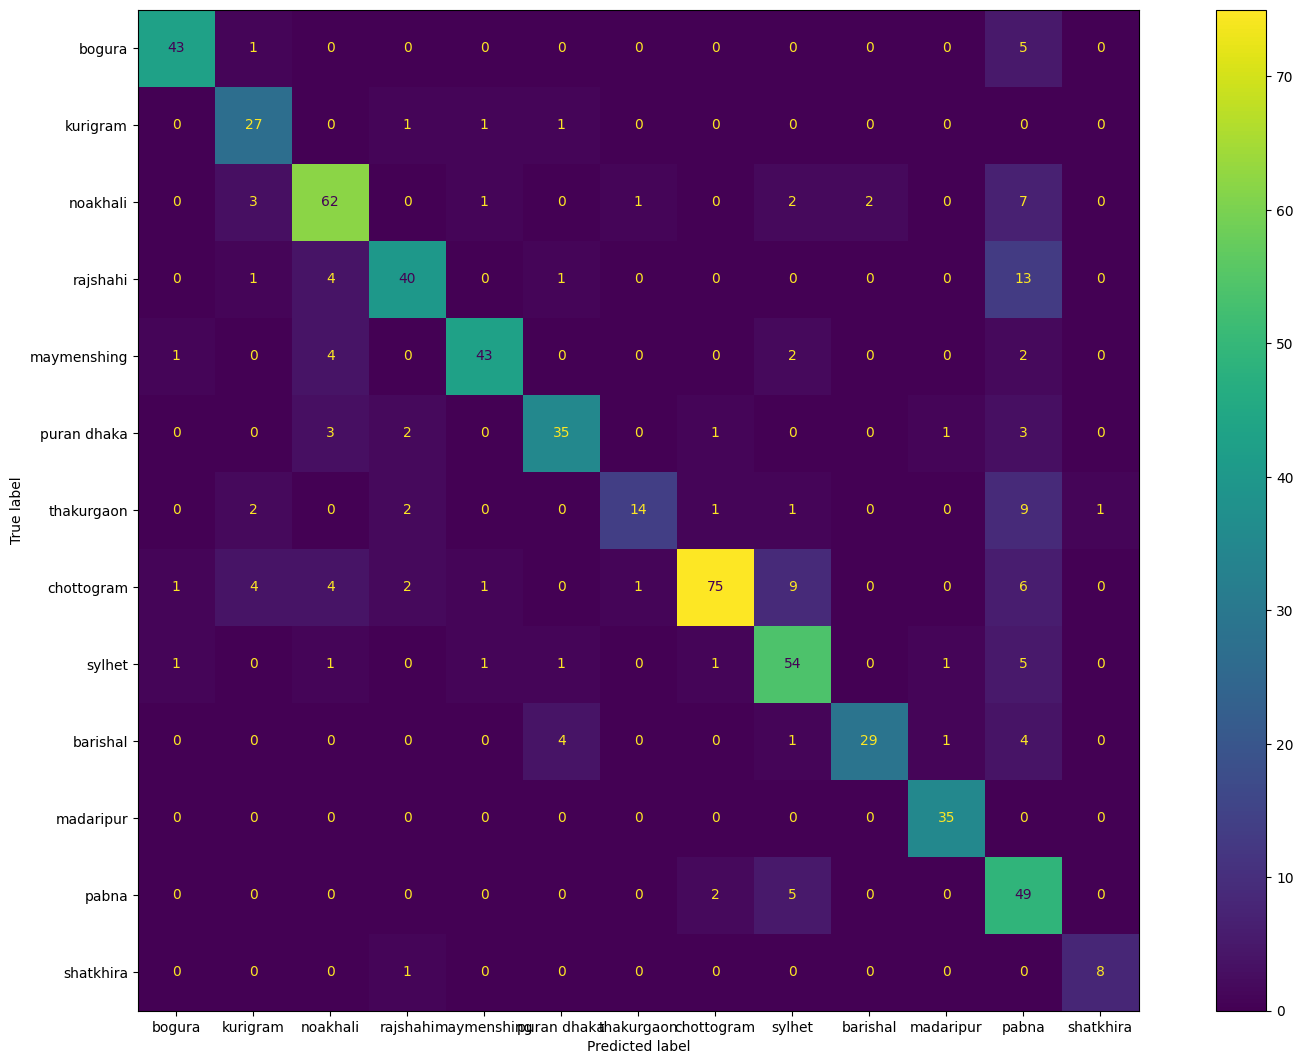

In [ ]:
show_confusion_matrix(X_test_reshaped, y_test, CNN2D_Model, num_labels, encoder)

## Performance on validation data

In [ ]:
show_evaluation_parameters(X_valid_reshaped, y_valid, CNN2D_Model, num_labels, encoder)

Accuracy score :  0.7753846153846153
Precision score:  0.8095491965710379
Recall score   :  0.7753846153846153
F1 Score       :  0.7776734177100176

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.96      0.59      0.73        46
      bogura       0.94      0.86      0.90        36
  chottogram       0.90      0.74      0.81        84
    kurigram       0.80      0.72      0.76        39
   madaripur       0.90      1.00      0.95        37
 maymenshing       0.90      0.80      0.85        56
    noakhali       0.80      0.80      0.80        86
       pabna       0.52      0.93      0.66        69
 puran dhaka       0.71      0.67      0.69        36
    rajshahi       0.81      0.81      0.81        37
   shatkhira       0.81      0.87      0.84        15
      sylhet       0.74      0.76      0.75        83
  thakurgaon       0.92      0.42      0.58        26

    accuracy                           0.78    

# Building LSTM model

In [ ]:
from tensorflow.keras.layers import LSTM

In [ ]:
lstm_model = tf.keras.Sequential()
# first layer after input layer
lstm_model.add(LSTM(128,input_shape=(128, 1)))
lstm_model.add(Dropout(0.2))
# second layer
lstm_model.add(Dense(100, activation='relu'))
# third layer
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dropout(0.2))
# forth layer
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dropout(0.2))
# output layer
lstm_model.add(Dense(num_labels, activation='softmax'))
lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 100)               12900     
                                                                 
 dense_13 (Dense)            (None, 100)               10100     
                                                                 
 dropout_12 (Dropout)        (None, 100)               0         
                                                                 
 dense_14 (Dense)            (None, 100)               10100     
                                                                 
 dropout_13 (Dropout)        (None, 100)              

In [ ]:
lstm_model.compile(optimizer='adam',
                   loss='CategoricalCrossentropy',
                   metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(X_train,
                              y_train,
                              epochs=50,
                              batch_size=5,
                              validation_data=(X_test, y_test),
                              shuffle=False)

Epoch 1/50
390/390 [==============================] - 7s 10ms/step - loss: 2.4627 - accuracy: 0.1467 - val_loss: 2.2847 - val_accuracy: 0.2308
Epoch 2/50
390/390 [==============================] - 5s 13ms/step - loss: 2.4078 - accuracy: 0.1862 - val_loss: 2.4282 - val_accuracy: 0.1385
Epoch 3/50
390/390 [==============================] - 4s 10ms/step - loss: 2.3981 - accuracy: 0.1949 - val_loss: 2.3023 - val_accuracy: 0.2308
Epoch 4/50
390/390 [==============================] - 3s 9ms/step - loss: 2.3005 - accuracy: 0.2405 - val_loss: 2.1599 - val_accuracy: 0.2646
Epoch 5/50
390/390 [==============================] - 5s 12ms/step - loss: 2.2476 - accuracy: 0.2564 - val_loss: 2.1387 - val_accuracy: 0.3031
Epoch 6/50
390/390 [==============================] - 4s 10ms/step - loss: 2.1877 - accuracy: 0.2728 - val_loss: 2.1373 - val_accuracy: 0.2923
Epoch 7/50
390/390 [==============================] - 3s 9ms/step - loss: 2.1648 - accuracy: 0.2944 - val_loss: 2.0427 - val_accuracy: 0.3169
E

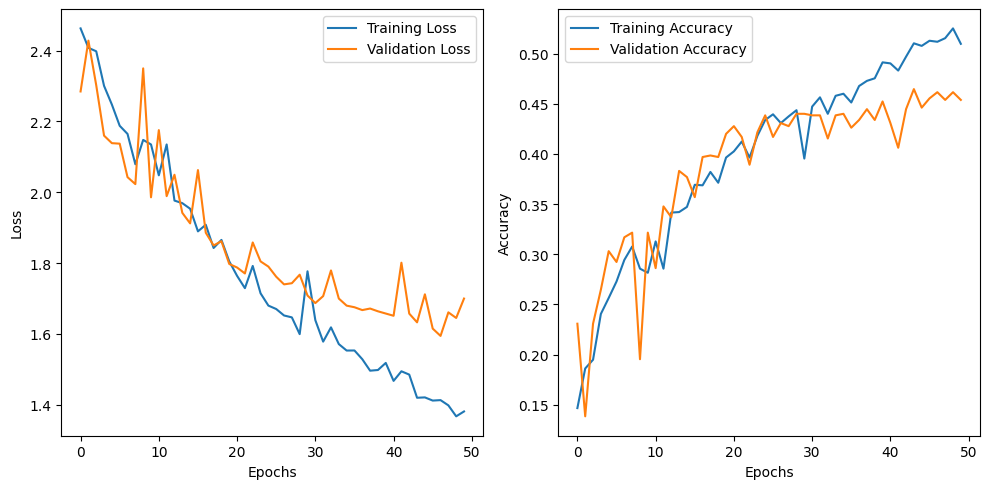

In [ ]:
plot_history(lstm_history)

In [ ]:
show_evaluation_parameters(X_test, y_test, lstm_model, num_labels, encoder)

Accuracy score :  0.45384615384615384
Precision score:  0.4889728001802722
Recall score   :  0.45384615384615384
F1 Score       :  0.45323504269603526

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.34      0.59      0.43        39
      bogura       0.93      0.57      0.71        49
  chottogram       0.87      0.57      0.69       103
    kurigram       0.39      0.40      0.39        30
   madaripur       0.41      0.74      0.53        35
 maymenshing       0.51      0.48      0.50        52
    noakhali       0.51      0.50      0.50        78
       pabna       0.23      0.32      0.27        56
 puran dhaka       0.07      0.02      0.03        45
    rajshahi       0.51      0.41      0.45        59
   shatkhira       0.00      0.00      0.00         9
      sylhet       0.33      0.54      0.41        65
  thakurgaon       0.31      0.17      0.22        30

    accuracy                           0.45 

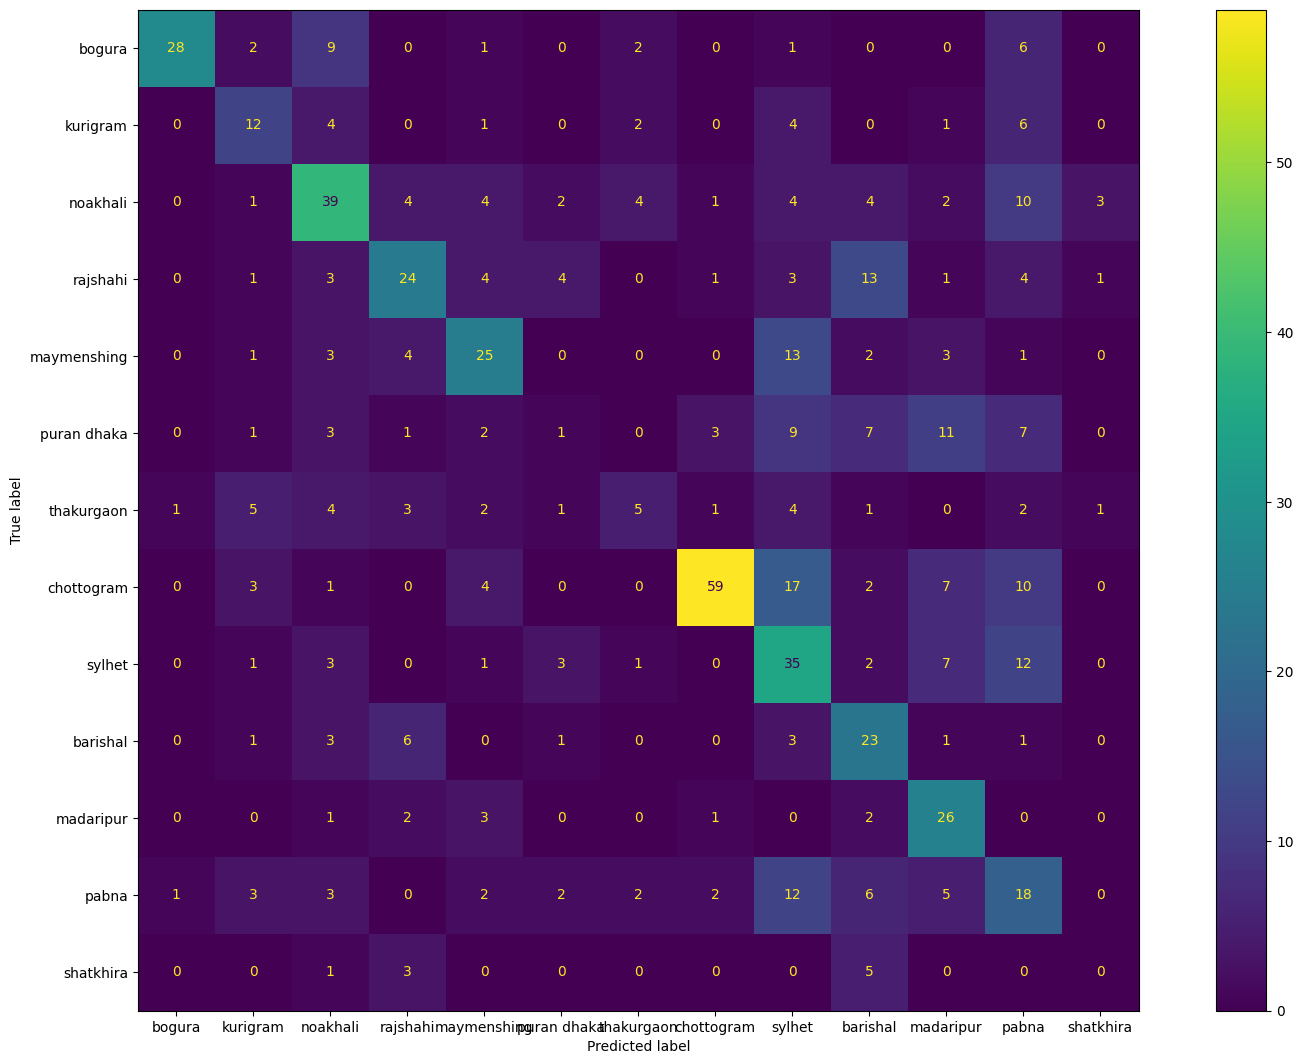

In [ ]:
show_confusion_matrix(X_test, y_test, lstm_model, num_labels, encoder)

## Performance on validation data

In [ ]:
show_evaluation_parameters(X_valid, y_valid, lstm_model, num_labels, encoder)

Accuracy score :  0.48
Precision score:  0.5026027885792975
Recall score   :  0.48
F1 Score       :  0.48186603055910765

--------------------------------------------

              precision    recall  f1-score   support

    barishal       0.40      0.54      0.46        46
      bogura       0.66      0.58      0.62        36
  chottogram       0.82      0.60      0.69        84
    kurigram       0.32      0.31      0.32        39
   madaripur       0.34      0.51      0.41        37
 maymenshing       0.73      0.62      0.67        56
    noakhali       0.63      0.52      0.57        86
       pabna       0.26      0.32      0.28        69
 puran dhaka       0.38      0.17      0.23        36
    rajshahi       0.43      0.54      0.48        37
   shatkhira       0.31      0.27      0.29        15
      sylhet       0.49      0.61      0.54        83
  thakurgaon       0.12      0.08      0.10        26

    accuracy                           0.48       650
   macro avg       0